In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import os
import shutil

In [16]:
dataset_drive_path = '/content/drive/MyDrive/Smart-Agriculture-System/'
# dataset_drive_path = '/content/drive/MyDrive/IT_Project/'

In [17]:
name = 'agriculture_sensors_minute_based.csv'
# name = 'agriculture_sensors_.csv'
drive_path = dataset_drive_path + name
print(drive_path)

if os.path.exists(drive_path):
  shutil.copy(drive_path, './')

/content/drive/MyDrive/Smart-Agriculture-System/agriculture_sensors_minute_based.csv


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [19]:
df = pd.read_csv(drive_path)

# Display basic information about the dataset
print(df.head())
print(df.info())

                        _id  humidity  temperature    light  soilMoisture  \
0  676d883c60a666999f426d6c     74.43        29.44  1771.95   2068.816531   
1  676d887960a666999f426d6e     74.80        29.59  1721.00   2123.848753   
2  676d88b660a666999f426d70     74.00        30.42  1990.15   1962.874345   
3  676d88f360a666999f426d72     74.00        30.44  1870.03   2072.463729   
4  676d893060a666999f426d74     73.97        30.46  1889.67   2058.482137   

    rainVolume  gasVolume                   fieldId                 createdAt  \
0  4095.000000      188.0  676d4559c3b9d9d8e1ac5828  2024-12-26T16:45:48.539Z   
1  4095.000000      168.0  676d4559c3b9d9d8e1ac5828  2024-12-26T16:46:49.714Z   
2  4095.000000      167.0  676d4559c3b9d9d8e1ac5828  2024-12-26T16:47:50.741Z   
3  3977.576096      166.0  676d4559c3b9d9d8e1ac5828  2024-12-26T16:48:51.876Z   
4  4075.465112      163.0  676d4559c3b9d9d8e1ac5828  2024-12-26T16:49:52.998Z   

                  updatedAt  __v                  

In [20]:
df = df.dropna()

In [21]:
# -------------------------------
# Add a new column: plant_health
# Rule: Healthy (1) if humidity in [73, 75], temperature in [29, 31],
# soilMoisture >= 2050, and light >= 1000; otherwise not healthy (0).
# Adjust these thresholds based on your domain knowledge.
def determine_health(row):
    if (50 <= row['humidity'] <= 80) and (23 <= row['temperature'] <= 31) and (1000 <= row['soilMoisture'] <= 4000) :
        return 1
    else:
        return 0

df['plant_health'] = df.apply(determine_health, axis=1)
print("After adding plant_health:")
print(df[['humidity', 'temperature', 'light', 'soilMoisture', 'plant_health']].head())

After adding plant_health:
   humidity  temperature    light  soilMoisture  plant_health
0     74.43        29.44  1771.95   2068.816531             1
1     74.80        29.59  1721.00   2123.848753             1
2     74.00        30.42  1990.15   1962.874345             1
3     74.00        30.44  1870.03   2072.463729             1
4     73.97        30.46  1889.67   2058.482137             1


In [22]:
print(df['plant_health'].value_counts())  # Check the count of 0s and 1s

plant_health
0    16505
1    16156
Name: count, dtype: int64


In [23]:
df.head()

,_id,humidity,temperature,light,soilMoisture,rainVolume,gasVolume,fieldId,createdAt,updatedAt,__v,addedAt,plant_health
0,676d883c60a666999f426d6c,74.43,29.44,1771.95,2068.816531,4095.000000,188.0,676d4559c3b9d9d8e1ac5828,2024-12-26T16:45:48.539Z,2025-01-07T10:04:48.522Z,0,2024-12-26T23:45:48.539Z,1
1,676d887960a666999f426d6e,74.80,29.59,1721.00,2123.848753,4095.000000,168.0,676d4559c3b9d9d8e1ac5828,2024-12-26T16:46:49.714Z,2025-01-07T10:04:48.522Z,0,2024-12-26T23:46:49.714Z,1
2,676d88b660a666999f426d70,74.00,30.42,1990.15,1962.874345,4095.000000,167.0,676d4559c3b9d9d8e1ac5828,2024-12-26T16:47:50.741Z,2025-01-07T10:04:48.522Z,0,2024-12-26T23:47:50.741Z,1
3,676d88f360a666999f426d72,74.00,30.44,1870.03,2072.463729,3977.576096,166.0,676d4559c3b9d9d8e1ac5828,2024-12-26T16:48:51.876Z,2025-01-07T10:04:48.522Z,0,2024-12-26T23:48:51.876Z,1
4,676d893060a666999f426d74,73.97,30.46,1889.67,2058.482137,4075.465112,163.0,676d4559c3b9d9d8e1ac5828,2024-12-26T16:49:52.998Z,2025-01-07T10:04:48.522Z,0,2024-12-26T23:49:52.998Z,1


In [24]:
# Filter rows where plant_health == 0
filtered_df = df[df["plant_health"] == 0]

# Print the result
print(filtered_df)

                            _id  humidity  temperature    light  soilMoisture  \
347    676e1d5760a666999f427022     69.87        30.60  1567.85   4023.085887   
348    676e1d9460a666999f427024     69.57        31.20  1800.27   4049.490113   
349    676e1dd160a666999f427026     69.63        31.50  1506.63   4026.565961   
350    676e1e0f60a666999f427028     69.17        31.37  1660.53   3962.978194   
351    676e1e4c60a666999f42702a     69.00        31.32  1566.78   3956.703300   
...                         ...       ...          ...      ...           ...   
32637  67a92a5437f4819d7e08f54f     66.00        27.44   251.08   4030.295837   
32640  67a92b4737f4819d7e08f555     66.00        27.38   243.00   4038.807933   
32652  67a92e5937f4819d7e08f56d     66.00        27.46   276.54   4034.237031   
32659  67a9303d37f4819d7e08f57b     66.00        27.49   258.56   4026.634874   
32674  67a934b937f4819d7e08f599     66.00        27.37   260.92   4010.541098   

        rainVolume  gasVolu

In [25]:
# -----------------------------
# Prepare data for modeling
# We drop columns that are not features (like IDs, timestamps, etc.)
# Adjust the list of columns to drop as needed.
drop_cols = ['_id', 'fieldId', 'createdAt', 'updatedAt', '__v', 'addedAt']
# Keep only the relevant features and the target column
data = df.drop(columns=drop_cols, errors='ignore')

In [26]:
# # Separate features (X) and target (y)
X = data.drop(columns=['plant_health'])
y = data['plant_health']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# # Train a RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train_scaled, y_train)


# Build a simple neural network
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1633/1633 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7141 - loss: 53.2709 - val_accuracy: 0.8330 - val_loss: 1.7589
Epoch 2/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8349 - loss: 1.0083 - val_accuracy: 0.8785 - val_loss: 0.4725
Epoch 3/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8613 - loss: 0.5634 - val_accuracy: 0.7947 - val_loss: 0.5508
Epoch 4/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8531 - loss: 0.5817 - val_accuracy: 0.8779 - val_loss: 0.5186
Epoch 5/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8563 - loss: 0.5394 - val_accuracy: 0.8749 - val_loss: 0.4941
Epoch 6/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8647 - loss: 0.4162 - val_accuracy: 0.9036 - val_loss: 0.2870
Epoch 7/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8546 - loss: 0.5219 - val_accuracy: 0.8935 - val_loss: 0.3062
Epoch 8/20
1633/1633 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8571 - loss: 0.4763 - val_accura

In [28]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [29]:
model.save('health_model.keras')

In [30]:
# Convert model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("health_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpph6dgx40'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135868823161744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135868823160400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135868793292368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135868793291984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135868793294288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135868793294096: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [31]:
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8975 - loss: 0.2294
Test Loss: 0.2366
Test Accuracy: 0.8948


ExactExplainer explainer: 6534it [01:36, 67.54it/s]                          


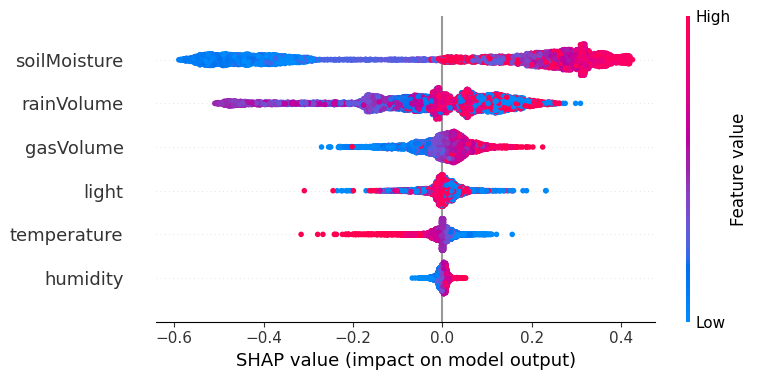

In [32]:
# # Plot feature importance
# feature_importances = pd.Series(model.feature_importances_, index=X.columns)
# plt.figure(figsize=(8, 6))
# feature_importances.sort_values(ascending=False).plot(kind='bar')
# plt.title('Feature Importance')
# plt.ylabel('Importance Score')
# plt.show()
# Ensure the number of features matches
feature_names = list(X_test.columns)  # Extract feature names dynamically

# Create an explainer
explainer = shap.Explainer(model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [33]:
# Define a new sample for testing
new_sample = {
    'humidity': [74.00],        # Lowered slightly
    'temperature': [29.42],     # More optimal temperature
    'light': [1500.15],         # Increased light exposure
    'soilMoisture': [2500],  # Balanced soil moisture
    'rainVolume': [4095.0],    # Reduced excessive rain
    'gasVolume': [200.0]       # Lower gas pollution
}
# Convert to DataFrame
new_data = pd.DataFrame(new_sample)

# Scale the new data
new_data_scaled = scaler.transform(new_data)

# Reshape if needed for model input
new_data_scaled = np.array(new_data_scaled)

In [34]:
# Use the trained model to predict plant health
prediction = model.predict(new_data_scaled)

# Convert to binary classification (assuming threshold 0.5)
predicted_class = (prediction[0] > 0.5).astype(int)

# Print the result
print("Raw Prediction:", prediction[0])
print("Prediction (0: not healthy, 1: healthy):", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Raw Prediction: [0.40094483]
Prediction (0: not healthy, 1: healthy): [0]


In [35]:
import pickle

In [36]:
with open("predict_health_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [37]:
with open("scaler_predict_health_model.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [38]:
df.to_csv("output.csv", index=False)